In [91]:
import os
from decouple import config
import second_level_functions as slf
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt

In [92]:
task = 'happy'
contrast = 'interaction'
threshold_pval = -np.log10(0.05)

In [93]:
base_dir = config(task)
path = os.path.join(base_dir, '2ndlevel', 'mixed_model')
images = slf.get_images(path)
contrasts = slf.contrast_imgs(images['t_stat'], images['pvals'])

In [94]:
parameter_estimates_df = slf.get_parameter_estimates(contrasts[contrast]['pvals'], threshold_pval, path, base_dir)
parameter_estimates_df['mean'] = parameter_estimates_df.iloc[0:,4:].mean(axis=1)

In [95]:
an_t1 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') & (parameter_estimates_df['time_point'] == 't1')]
an_t2 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') & (parameter_estimates_df['time_point'] == 't2')]

hc_t1 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') & (parameter_estimates_df['time_point'] == 't1')]
hc_t2 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') & (parameter_estimates_df['time_point'] == 't2')]

<AxesSubplot: xlabel='time_point', ylabel='mean'>

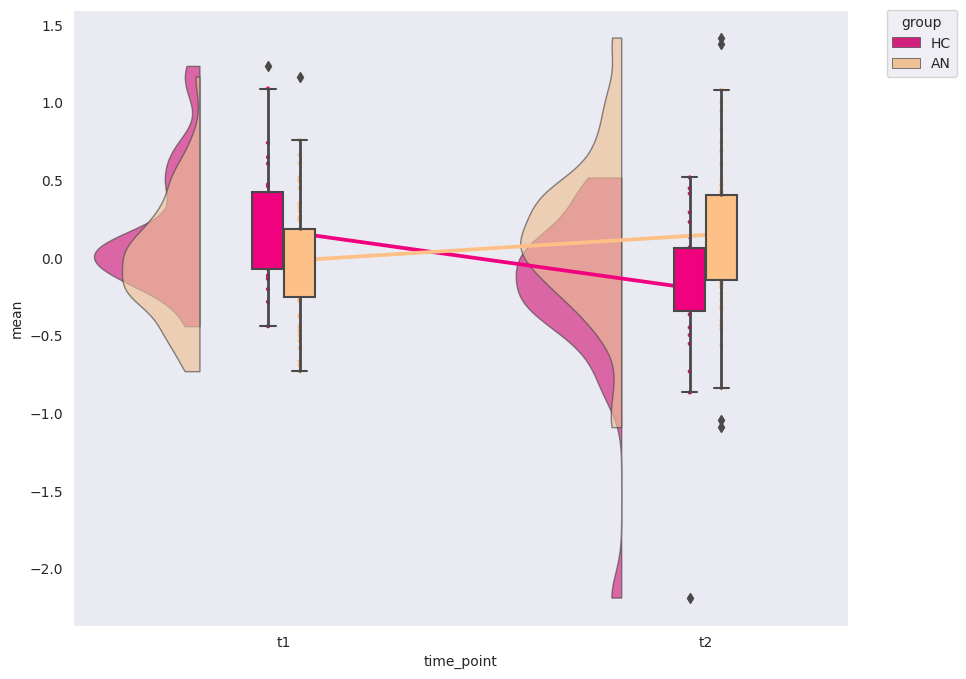

In [96]:
fig,ax = plt.subplots(1,1, figsize=(10, 8))
pt.RainCloud(
    x="time_point", 
    y="mean", 
    hue="group", 
    data=parameter_estimates_df, 
    palette='Accent_r', 
    alpha = .65, 
    dodge = True, 
    scale = "area",
    ax=ax,
    width_viol=.5,
    jitter=0,
    pointplot = True,
    bw = .3
     )



In [97]:
means_std_df = pd.DataFrame(data={
    'AN mean':  [an_t1['mean'].mean(), an_t2['mean'].mean()],
    'HC mean': [hc_t1['mean'].mean(), hc_t2['mean'].mean()],
    'AN std': [an_t1['mean'].std(), an_t2['mean'].std()],
    'HC std': [hc_t1['mean'].std(), hc_t2['mean'].std()]
                   }, index=['T1', 'T2']) 
means_std_df

,AN mean,HC mean,AN std,HC std
T1,-0.015401,0.185133,0.374687,0.402121
T2,0.153574,-0.194740,0.484807,0.526120


In [103]:
import scipy.stats as stats

stats.ttest_rel(hc_t1['mean'], hc_t2['mean'])

Ttest_relResult(statistic=3.1567982286358878, pvalue=0.004009077531638415)

In [105]:
import statsmodels.formula.api as smf


model = smf.mixedlm("mean ~ time_point + group + group:time_point", 
                    parameter_estimates_df, 
                    groups=parameter_estimates_df["sub"]).fit()
print(model.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      mean     
No. Observations:       184          Method:                  REML     
No. Groups:             92           Scale:                   0.1968   
Min. group size:        2            Log-Likelihood:          -116.5896
Max. group size:        2            Converged:               Yes      
Mean group size:        2.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    -0.015    0.055 -0.280 0.780 -0.123  0.092
time_point[T.t2]              0.169    0.078  2.171 0.030  0.016  0.322
group[T.HC]                   0.201    0.102  1.974 0.048  0.001  0.400
group[T.HC]:time_point[T.t2] -0.549    0.144 -3.821 0.000 -0.830 -0.267
Group Var

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [99]:
null = smf.mixedlm("mean ~ time_point + sub:time_point", 
                    parameter_estimates_df, 
                    groups=parameter_estimates_df["sub"]).fit()

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [100]:
bayes_factor = model.llf / null.llf
bayes_factor

0.9059536655894572